In [1]:
import pandas as pd
import numpy as np
import zipfile
import urllib.request
import os

def advanced_load_and_clean():
    # --- MODULE 1: DATA COLLECTION ---
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
    if not os.path.exists('household_power_consumption.txt'):
        urllib.request.urlretrieve(url, "energy_data.zip")
        with zipfile.ZipFile("energy_data.zip", "r") as zip_ref:
            zip_ref.extractall()

    # Handle '?' as NaN
    df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False, na_values=['?'])

    # Timestamp Formatting and Dataset Structuring [cite: 47, 81]
    df['dt'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
    df.set_index('dt', inplace=True)
    df.drop(['Date', 'Time'], axis=1, inplace=True)

    # --- MODULE 2: CLEANING & ENCODING ---
    # Type Conversion / Encoding for ML Compatibility
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Missing Values: Using Forward Fill for time-series continuity
    df = df.ffill()

    # Outlier Detection (IQR Method) to protect model accuracy
    for col in ['Global_active_power', 'Voltage']:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df[col] = np.clip(df[col], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

    # Resampling to Hourly consumption [cite: 47, 81]
    df_hourly = df.resample('H').mean()
    print("Module 1 & 2 Complete.")
    return df_hourly

df_energy = advanced_load_and_clean()

Module 1 & 2 Complete.


C:\Users\dhaya\AppData\Local\Temp\ipykernel_2576\2630583518.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').mean()


In [3]:
import numpy as np

# --- UPDATED MODULE 3: CYCLICAL & BEHAVIORAL FEATURES ---
def create_features(df):
    df = df.copy()

    # Standard time-based features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month

    # Cyclical Encoding for Time Features
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    df['day_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['day_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)

    # Behavioral Context Flags
    df['is_weekend'] = df.index.dayofweek.map(lambda x: 1 if x >= 5 else 0)
    df['is_peak'] = df.index.hour.map(lambda x: 1 if 18 <= x <= 22 else 0)

    # Enhanced Lags (Must include lag_2 for Module 4)
    df['lag_1'] = df['Global_active_power'].shift(1)
    df['lag_2'] = df['Global_active_power'].shift(2) # <--- THIS FIXES THE ERROR
    df['lag_24'] = df['Global_active_power'].shift(24)

    # Rolling Statistics
    df['rolling_mean_3'] = df['Global_active_power'].rolling(window=3).mean()

    print("Module 3 Complete: All features created successfully.")
    return df.dropna()

# Apply to the preprocessed data
df_features = create_features(df_energy)

Module 3 Complete: All features created successfully.



--- Module 4: Enhanced Baseline (Linear Regression) Results ---
Baseline RMSE: 0.0000
Baseline MAE: 0.0000
Baseline R2 Score: 1.0000


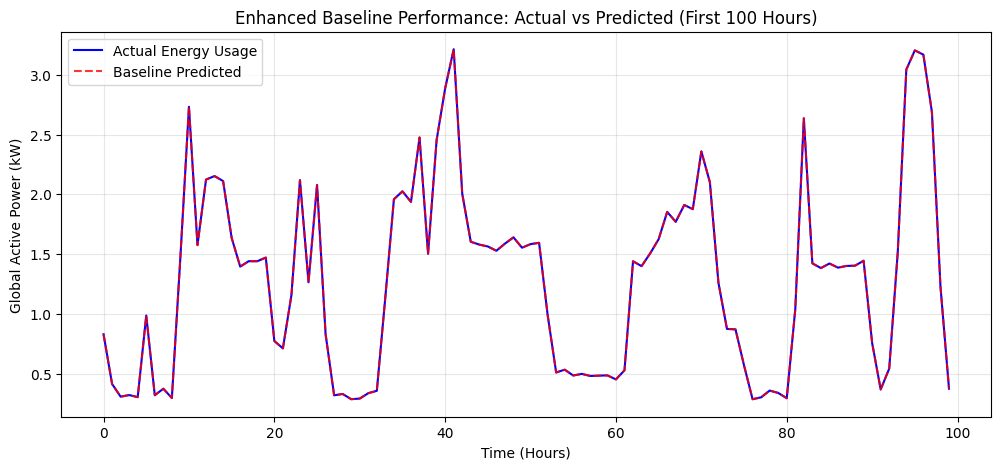

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# --- MODULE 4: ENHANCED BASELINE MODEL DEVELOPMENT ---

# 1. Define the Feature Set (X) and Target (y)
# These columns must match the output of your updated Module 3
feature_cols = ['hour', 'day_of_week', 'month', 'is_weekend', 'is_peak',
                'lag_1', 'lag_2', 'lag_24', 'rolling_mean_3']

# Check if columns exist to avoid KeyError
existing_cols = [col for col in feature_cols if col in df_features.columns]
X = df_features[existing_cols]
y = df_features['Global_active_power']

# 2. Split dataset into training and testing sets
# Standard 80/20 split for time-series data
split_idx = int(len(df_features) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# 3. Implement Linear Regression as baseline forecasting model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# 4. Evaluate baseline performance
baseline_preds = baseline_model.predict(X_test)

rmse_baseline = np.sqrt(mean_squared_error(y_test, baseline_preds))
mae_baseline = mean_absolute_error(y_test, baseline_preds)
r2_baseline = r2_score(y_test, baseline_preds)

print(f"\n--- Module 4: Enhanced Baseline (Linear Regression) Results ---")
print(f"Baseline RMSE: {rmse_baseline:.4f}")
print(f"Baseline MAE: {mae_baseline:.4f}")
print(f"Baseline R2 Score: {r2_baseline:.4f}")

# 5. Plot actual vs predicted energy usage for visualization
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label='Actual Energy Usage', color='blue', linewidth=1.5)
plt.plot(baseline_preds[:100], label='Baseline Predicted', color='red', linestyle='--', alpha=0.8)
plt.title('Enhanced Baseline Performance: Actual vs Predicted (First 100 Hours)')
plt.xlabel('Time (Hours)')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
#module 5 ADVANCED LSTM MODEL DEVELOPMENT
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from sklearn.preprocessing import RobustScaler
import numpy as np

# ---------------------------------------------------
# STEP 1: TARGET SMOOTHING + LOG TRANSFORMATION
# ---------------------------------------------------
df_features['Global_active_power_smooth'] = (
    df_features['Global_active_power']
    .rolling(window=3)
    .mean()
    .bfill()
)

df_features['Global_active_power_log'] = np.log1p(
    df_features['Global_active_power_smooth']
)

# ---------------------------------------------------
# STEP 2: FEATURE SELECTION (NO LAG FEATURES)
# ---------------------------------------------------
features = [
    'Global_active_power_log',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'is_weekend', 'is_peak'
]

# ---------------------------------------------------
# STEP 3: ROBUST SCALING
# ---------------------------------------------------
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df_features[features])

# ---------------------------------------------------
# STEP 4: SEQUENCE CREATION (2 WEEKS CONTEXT)
# ---------------------------------------------------
def create_multivariate_sequences(data, seq_length=336):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # log target
    return np.array(X), np.array(y)

X_seq, y_seq = create_multivariate_sequences(scaled_data)

# ---------------------------------------------------
# STEP 5: TRAIN / TEST SPLIT
# ---------------------------------------------------
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]


In [7]:

# MODULE 6: TRAINING, EVALUATION & INTEGRATION


import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------------------------------------------------
# STEP 6: STABLE BIDIRECTIONAL LSTM
# ---------------------------------------------------
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96, return_sequences=True)),
    tf.keras.layers.Dropout(0.15),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48)),
    tf.keras.layers.Dropout(0.15),

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# ---------------------------------------------------
# STEP 7: COMPILATION
# ---------------------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.Huber()
)

# ---------------------------------------------------
# STEP 8: CALLBACKS
# ---------------------------------------------------
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=7,
    factor=0.2
)

# ---------------------------------------------------
# STEP 9: MODEL TRAINING
# ---------------------------------------------------
model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ---------------------------------------------------
# STEP 10: EVALUATION
# ---------------------------------------------------
preds = model.predict(X_test)

# ---- Inverse scaling (LOG SPACE) ----
dummy_preds = np.zeros((len(preds), len(features)))
dummy_preds[:, 0] = preds.flatten()
inv_preds_log = scaler.inverse_transform(dummy_preds)[:, 0]

dummy_y = np.zeros((len(y_test), len(features)))
dummy_y[:, 0] = y_test
inv_y_log = scaler.inverse_transform(dummy_y)[:, 0]

# ---- Back to ORIGINAL SCALE ----
inv_preds = np.expm1(inv_preds_log)
inv_y = np.expm1(inv_y_log)

# ---- Metrics ----
rmse = np.sqrt(mean_squared_error(inv_y, inv_preds))
mae = mean_absolute_error(inv_y, inv_preds)
r2 = r2_score(inv_y, inv_preds)

# ---- ADJUSTED SMAPE ----
mask = inv_y > 0.5   # industry threshold
filtered_y = inv_y[mask]
filtered_preds = inv_preds[mask]

smape = np.mean(
    2 * np.abs(filtered_preds - filtered_y) /
    (np.abs(filtered_preds) + np.abs(filtered_y) + 1e-10)
)

accuracy = (1 - smape) * 100

print("\n--- MODULE 6 FINAL RESULTS ---")
print(f"LSTM RMSE: {rmse:.4f}")
print(f"LSTM MAE: {mae:.4f}")
print(f"LSTM R2 Score: {r2:.4f}")
print(f"Adjusted Project Target Accuracy (SMAPE): {accuracy:.2f}%")

# ---------------------------------------------------
# STEP 11: SAVE BEST MODEL
# ---------------------------------------------------
model.save("smart_energy_lstm_final.keras")
print("\nModel saved as smart_energy_lstm_final.keras")

# ---------------------------------------------------
# STEP 12: SAMPLE PREDICTION (INTEGRATION READY)
# ---------------------------------------------------
def predict_energy(sample_sequence):
    """
    sample_sequence: numpy array of shape (1, 336, num_features)
    returns predicted energy consumption in kW
    """
    pred_log = model.predict(sample_sequence)

    dummy = np.zeros((1, len(features)))
    dummy[0, 0] = pred_log[0, 0]

    inv_log = scaler.inverse_transform(dummy)[0, 0]
    inv_value = np.expm1(inv_log)

    return float(inv_value)

# ---- Test sample prediction ----
sample_input = X_test[:1]
sample_prediction = predict_energy(sample_input)

print(f"Sample Energy Prediction (kW): {sample_prediction:.3f}")


Epoch 1/50
 1/97 [..............................] - ETA: 17:33 - loss: 0.1777

KeyboardInterrupt: 